In [1]:
from PIL import Image
import os
import shutil
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Flatten, Dense, Dropout)
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import warnings

2025-04-26 13:21:20.657465: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path='/Users/gamalielmarines/Downloads/CNN-Reto-Benji/ALL Image Dataset/Original'
pd.DataFrame(os.listdir(path),columns=['Files'])

Files
0      Early
1  .DS_Store
2        Pro
3     Benign
4        Pre

In [3]:
data_dir =path
batch_size = 32
target_size = (224, 224)

train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.4,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.20,
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.20,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

Found 3256 files belonging to 4 classes.
Using 1954 files for training.
Found 3256 files belonging to 4 classes.
Using 651 files for validation.
Found 3256 files belonging to 4 classes.
Using 651 files for validation.


In [4]:
class_names = train.class_names
print("Class Names:", class_names)

Class Names: ['Benign', 'Early', 'Pre', 'Pro']


In [5]:
train_size = len(list(train))
val_size = len(list(validation))
test_size = len(list(test))

2025-04-26 13:21:36.134536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-26 13:21:36.726384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-26 13:21:37.211793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
print("Train Size:", train_size, "Validation Size:", val_size, "Test Size:", test_size)

Train Size: 62 Validation Size: 21 Test Size: 21


In [7]:
train_class_counts = np.zeros(len(class_names))
val_class_counts = np.zeros(len(class_names))
test_class_counts = np.zeros(len(class_names))

for images, labels in train:
    for label in labels.numpy():
        train_class_counts[label] += 1

for images, labels in validation:
    for label in labels.numpy():
        val_class_counts[label] += 1

for images, labels in test:
    for label in labels.numpy():
        test_class_counts[label] += 1


2025-04-26 13:21:37.754273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-26 13:21:38.025251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-26 13:21:38.234766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
print("Train Class Counts:", train_class_counts)
print("Validation Class Counts:", val_class_counts)
print("Test Class Counts:", test_class_counts)

Train Class Counts: [331. 567. 578. 478.]
Validation Class Counts: [111. 190. 194. 156.]
Test Class Counts: [ 95. 191. 206. 159.]


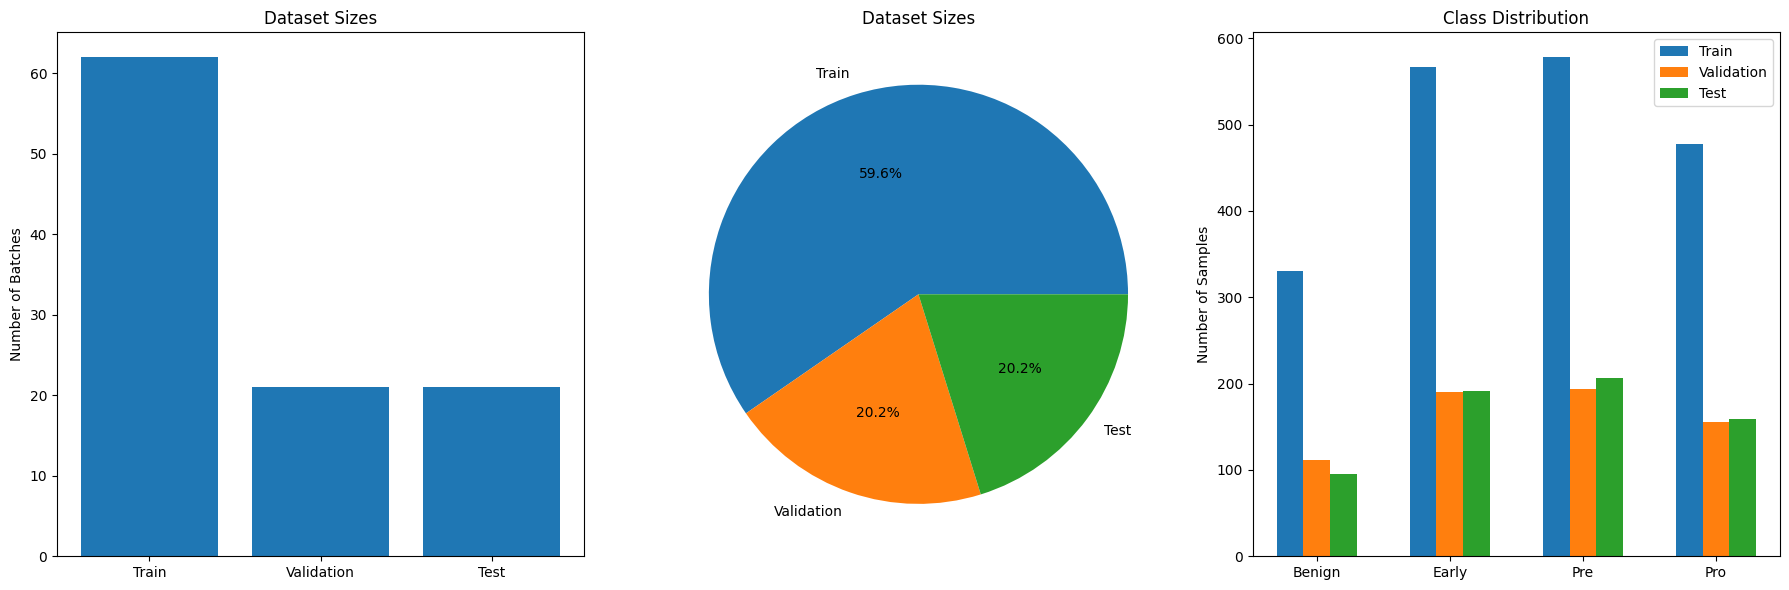

In [9]:
# Plot the sizes of the datasets
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.bar(['Train', 'Validation', 'Test'], [train_size, val_size, test_size])
plt.title('Dataset Sizes')
plt.ylabel('Number of Batches')

# Plot the class distribution in each dataset
x = np.arange(len(class_names))
width = 0.2

plt.subplot(1, 3, 2)
plt.pie([train_size, val_size, test_size], labels=['Train', 'Validation', 'Test'], autopct='%1.1f%%')
plt.title('Dataset Sizes')

plt.subplot(1, 3, 3)
plt.bar(x - width, train_class_counts, width, label='Train')
plt.bar(x, val_class_counts, width, label='Validation')
plt.bar(x + width, test_class_counts, width, label='Test')
plt.xticks(x, class_names)
plt.title('Class Distribution')
plt.ylabel('Number of Samples')
plt.legend()

plt.tight_layout()
plt.show()

2025-04-26 13:21:40.060371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


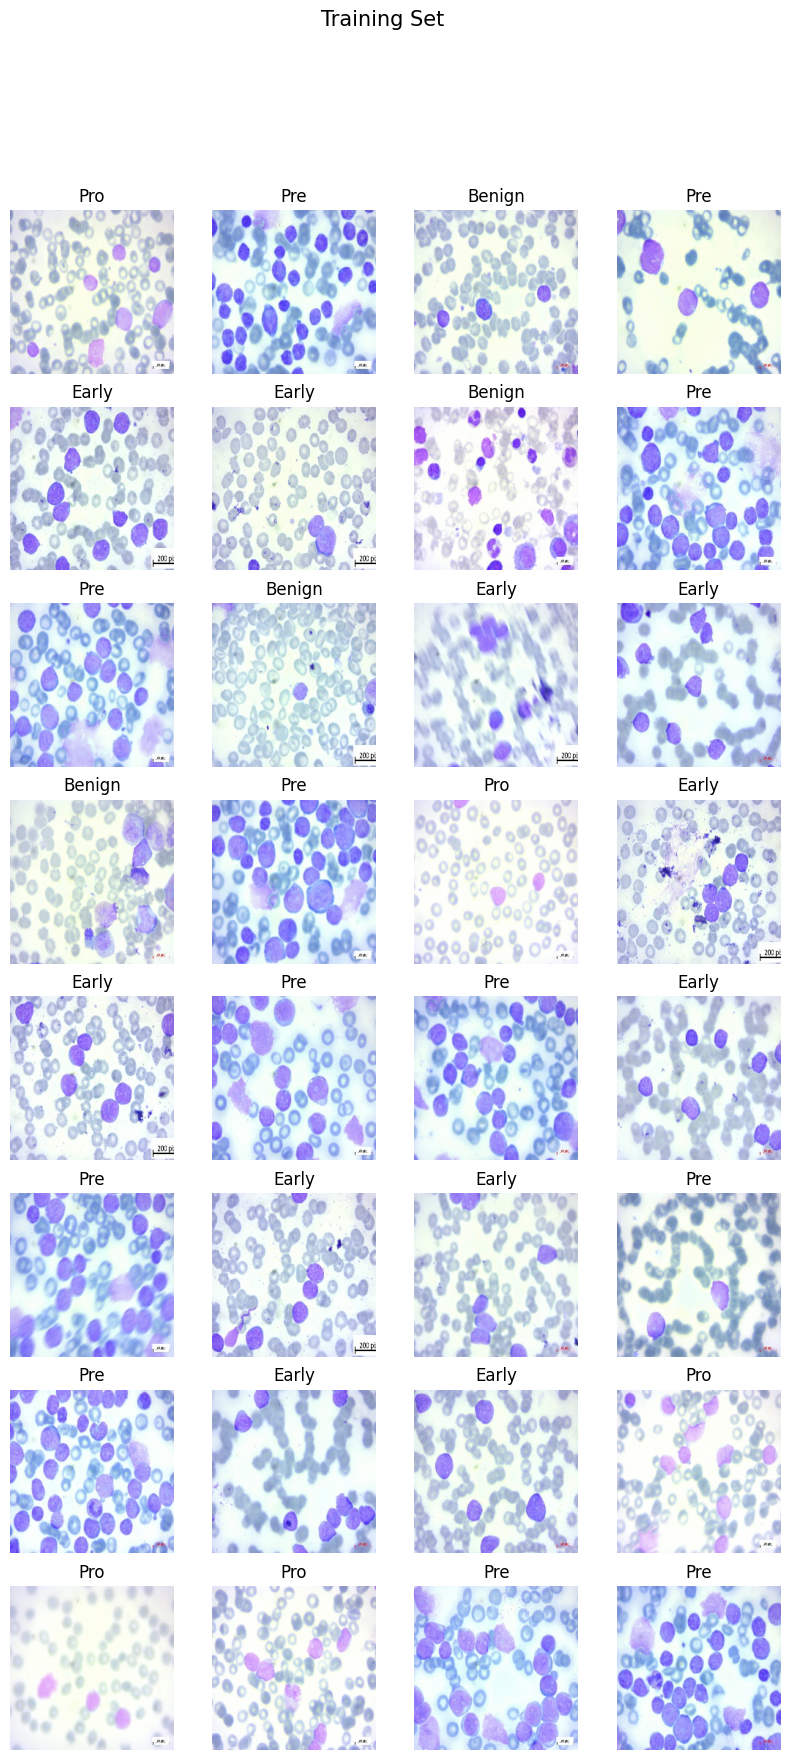

In [10]:
def plot_dataset(dataset, title):
    plt.figure(figsize=(10, 20))
    for images, labels in dataset.take(1):
        for i in range(32):
            ax = plt.subplot(8, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.suptitle(title, fontsize=15)
    plt.show()

# Plot training set
plot_dataset(train, "Training Set")

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow import keras

base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='/Users/gamalielmarines/Downloads/CNN-Reto-Benji/ResNet50 Weights.h5'
)

base_model.trainable = False

model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


checkpoint_cb = ModelCheckpoint("restnet_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=4, restore_best_weights=True)

hist = model.fit(
    train,
    class_weight={0: 0.1, 1: 1.0, 2: 1.0, 3: 1.0},
    epochs=8,
    validation_data=validation,
    callbacks=[checkpoint_cb, early_stopping_cb]
)


Epoch 1/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.4081 - loss: 1.6924 - val_accuracy: 0.8049 - val_loss: 1.1784
Epoch 2/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7305 - loss: 0.3888 - val_accuracy: 0.8126 - val_loss: 0.9261
Epoch 3/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.7830 - loss: 0.2354 - val_accuracy: 0.8172 - val_loss: 0.6778
Epoch 4/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8043 - loss: 0.1745 - val_accuracy: 0.8264 - val_loss: 0.3948
Epoch 5/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.8248 - loss: 0.1644 - val_accuracy: 0.8203 - val_loss: 0.4588
Epoch 6/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 670s 11s/step - accuracy: 0.8487 - loss: 0.1179 - val_accuracy: 0.8295 - val_loss: 0.4115
Epoch 7/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 353s 6s/step - accuracy: 0.8484 - loss: 0.1178 - val_accuracy: 0.9247 - val_loss: 0.2051
Epoch 8/8
62/62 ━━━━━━━━━━━━━━━━━━━━ 888s 15s/step - accuracy: 0.8869 - loss: 0.0929 - val_accuracy: 0.9124 - val_los

In [12]:
score, acc = model.evaluate(test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9291 - loss: 0.1685
Test Loss = 0.16241668164730072
Test Accuracy = 0.9262672662734985


In [13]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0  0.527636  1.054861      0.804915  1.178421
1  0.753838  0.329222      0.812596  0.926073
2  0.790686  0.221845      0.817204  0.677816
3  0.814739  0.165525      0.826421  0.394834
4  0.835722  0.145125      0.820276  0.458774
5  0.858240  0.117386      0.829493  0.411510
6  0.866428  0.108246      0.924731  0.205145
7  0.888434  0.091091      0.912442  0.209050

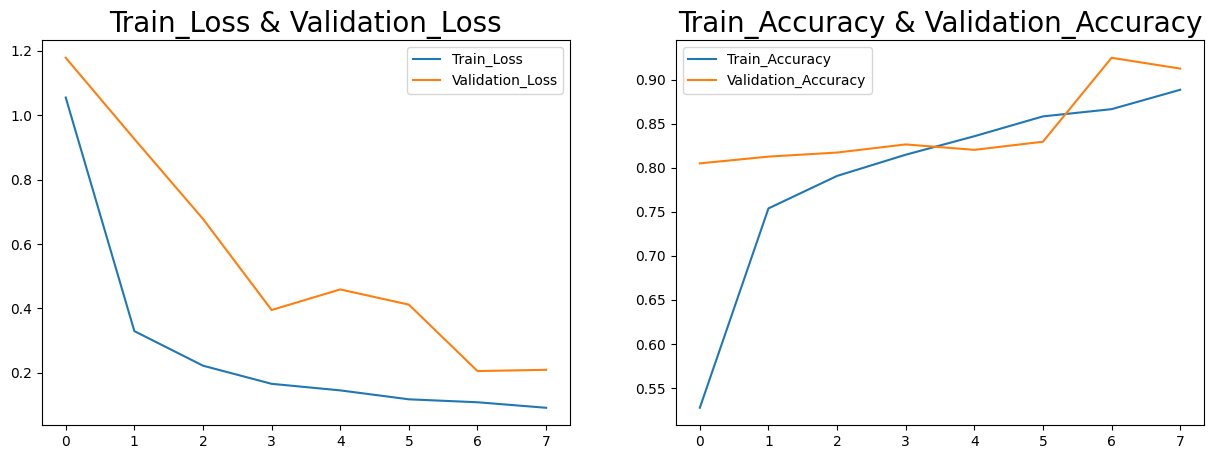

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step


2025-04-26 14:11:39.368085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


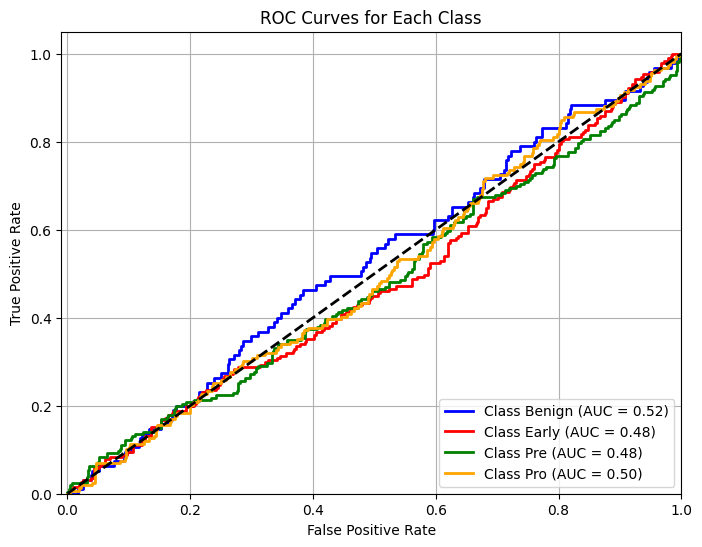

In [17]:
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test dataset
y_pred_proba = model.predict(test)

# Get true labels
y_true = []
for _, labels in test:
    y_true.extend(labels.numpy())

# Binarize the labels for one-vs-rest
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.grid()
plt.show()

2025-04-26 14:11:47.880269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step


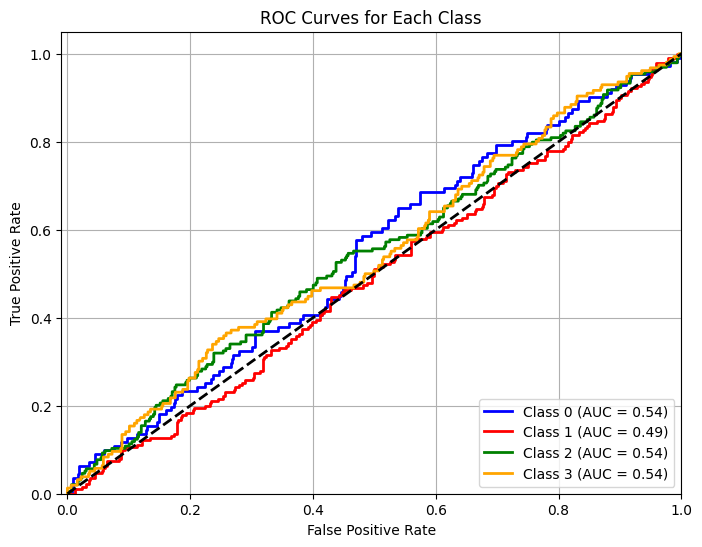

In [18]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Extract true labels efficiently
y_true = tf.concat([labels for images, labels in validation], axis=0).numpy()

# 2. Binarize the labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# 3. Predict probabilities
y_pred_proba = model.predict(validation)

# 4. Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 5. Plot all ROC curves
plt.figure(figsize=(8,6))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
X_val,y_val,y_pred=[],[],[]
for images, labels in test:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

2025-04-23 12:51:26.941976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step


Actual  Prediction
0         2           2
1         0           1
2         1           1
3         0           0
4         1           1
..      ...         ...
646       2           2
647       1           1
648       0           0
649       2           2
650       3           3

[651 rows x 2 columns]

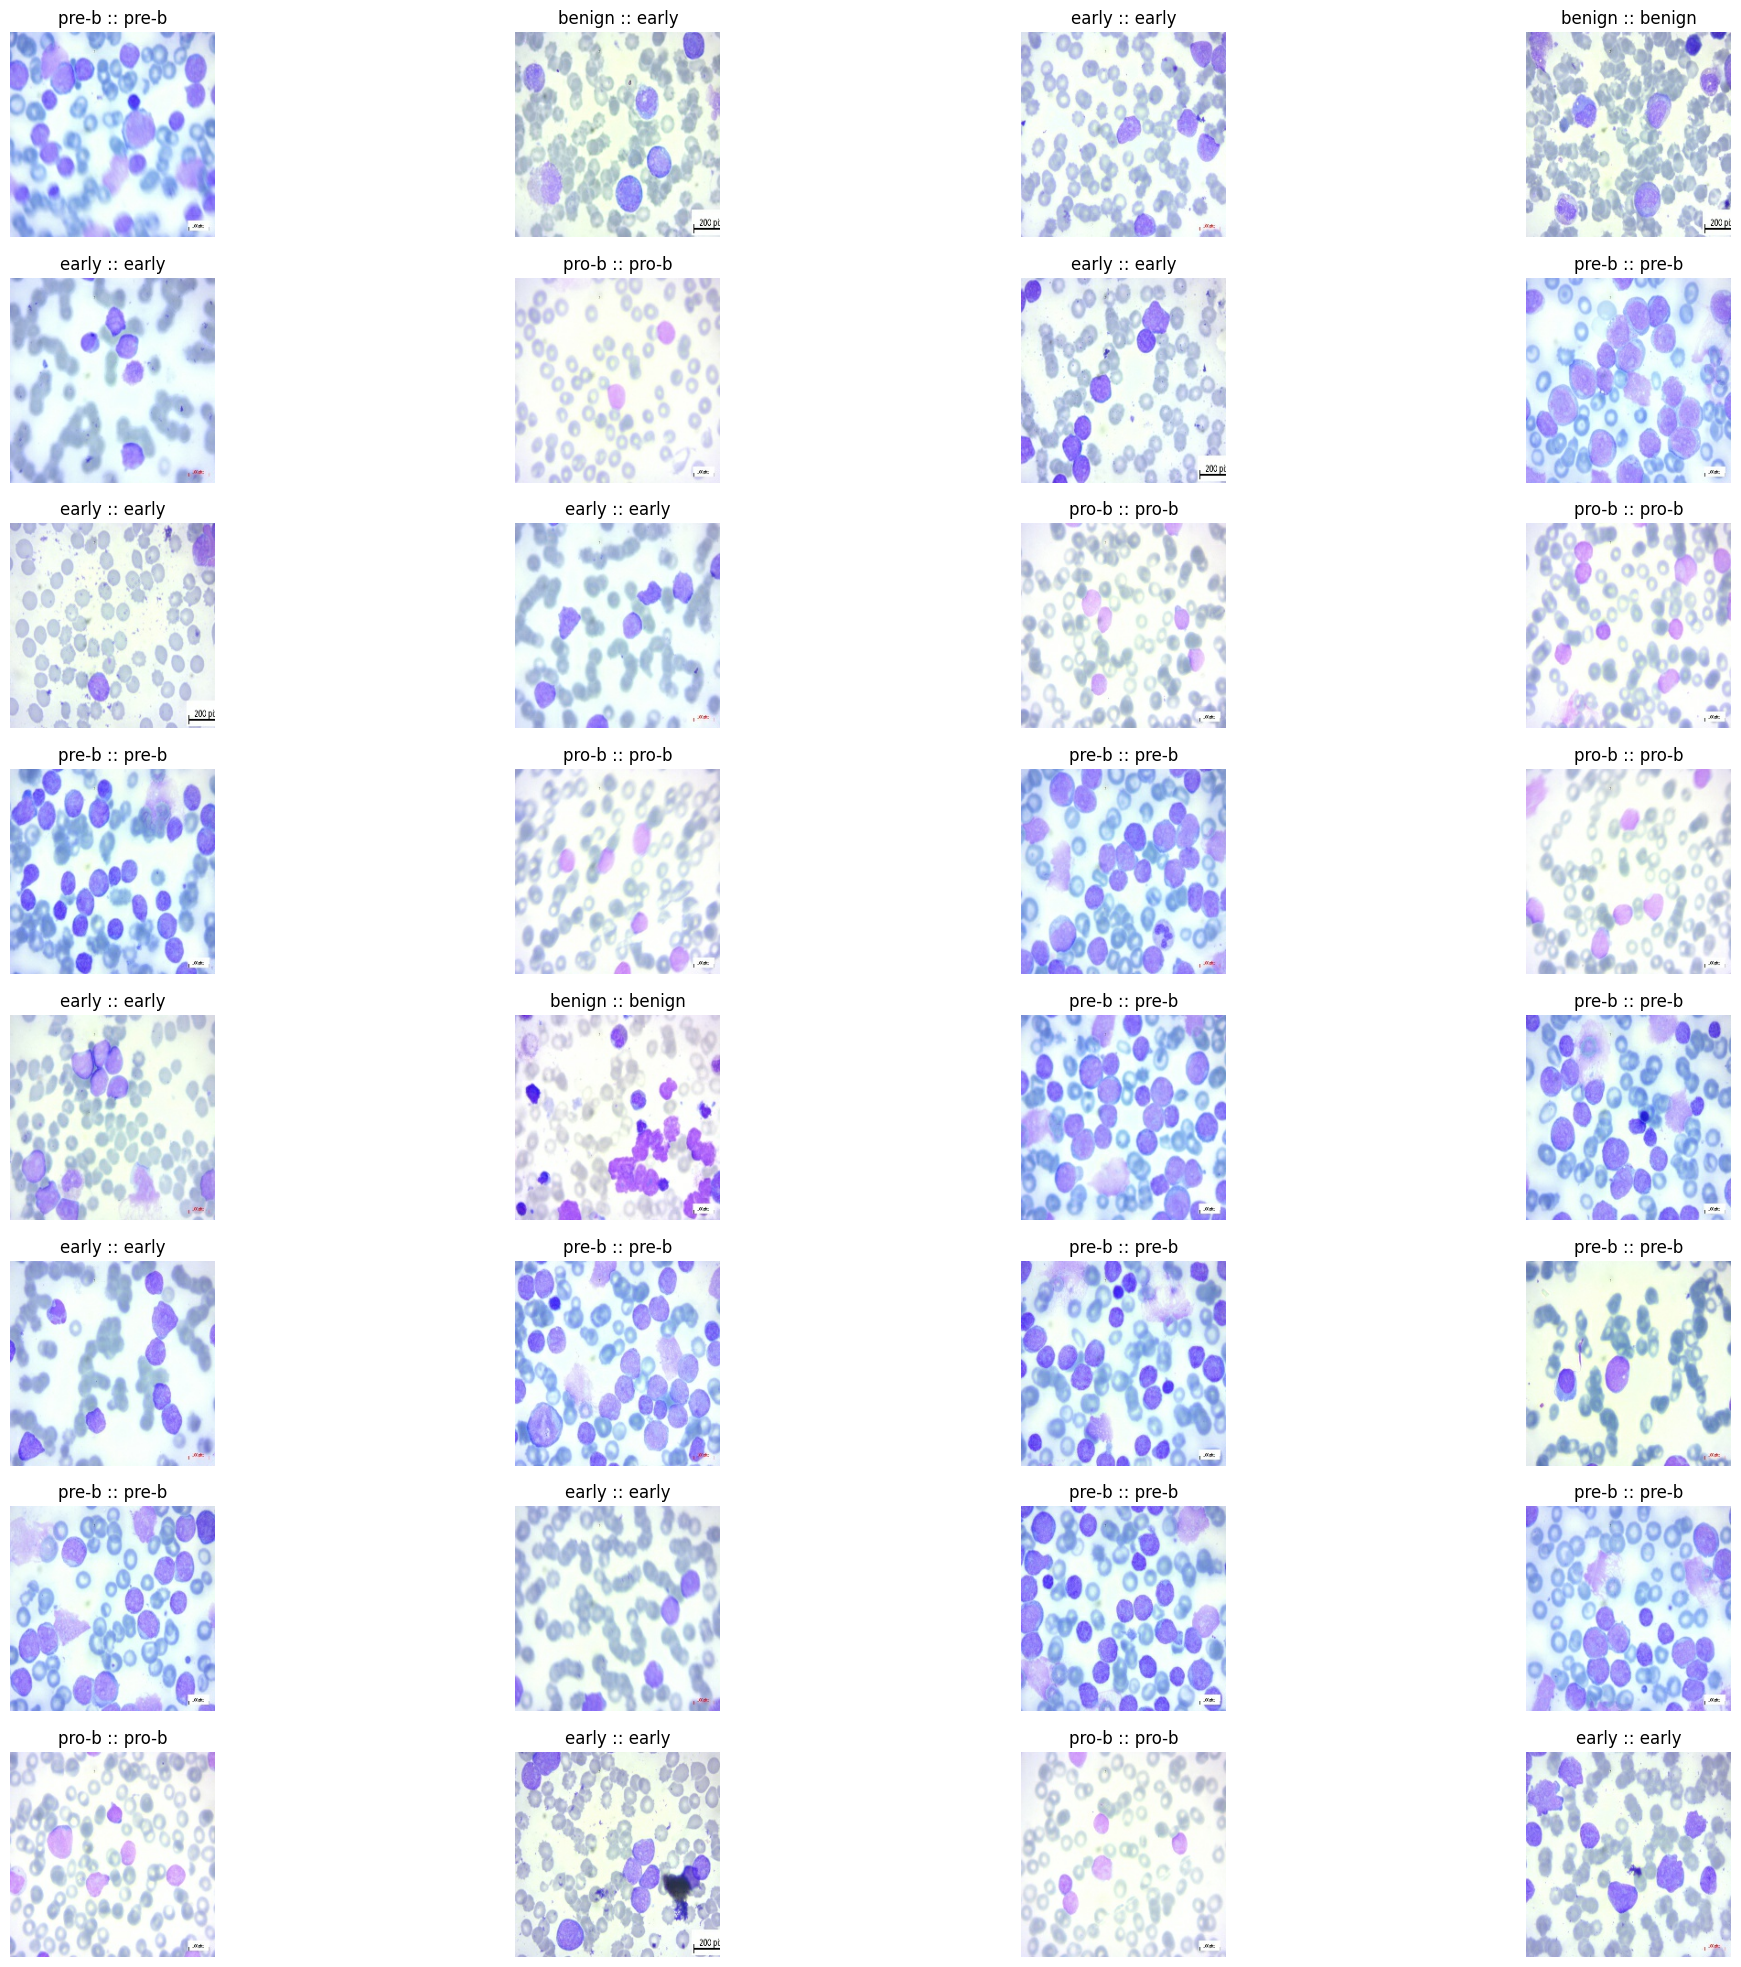

In [ ]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

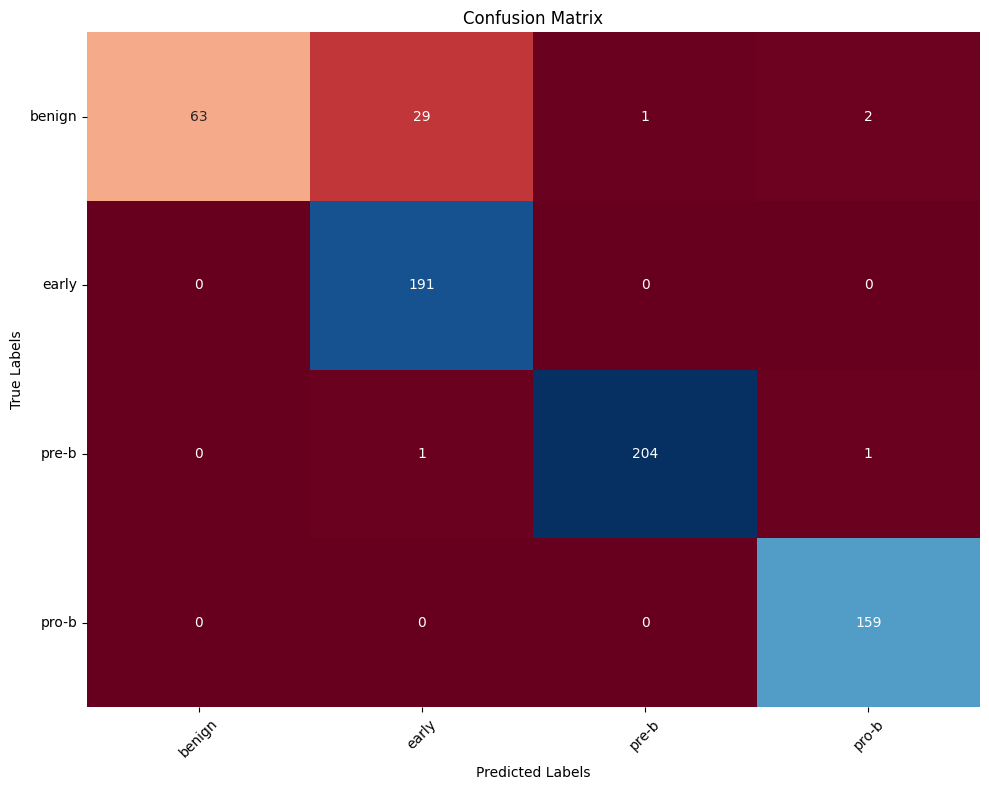

array([[ 63,  29,   1,   2],
       [  0, 191,   0,   0],
       [  0,   1, 204,   1],
       [  0,   0,   0, 159]])

In [ ]:
CM = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax=ax, cbar=False, cmap='RdBu',
            xticklabels=class_names, yticklabels=class_names)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels') 
ax.set_title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

CM

In [ ]:
ClassificationReport = classification_report(y_val,y_pred)
print('Classification Report is : ')
print(ClassificationReport)

Classification Report is : 
              precision    recall  f1-score   support

           0       1.00      0.66      0.80        95
           1       0.86      1.00      0.93       191
           2       1.00      0.99      0.99       206
           3       0.98      1.00      0.99       159

    accuracy                           0.95       651
   macro avg       0.96      0.91      0.93       651
weighted avg       0.95      0.95      0.94       651



21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step


2025-04-23 12:52:57.982114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


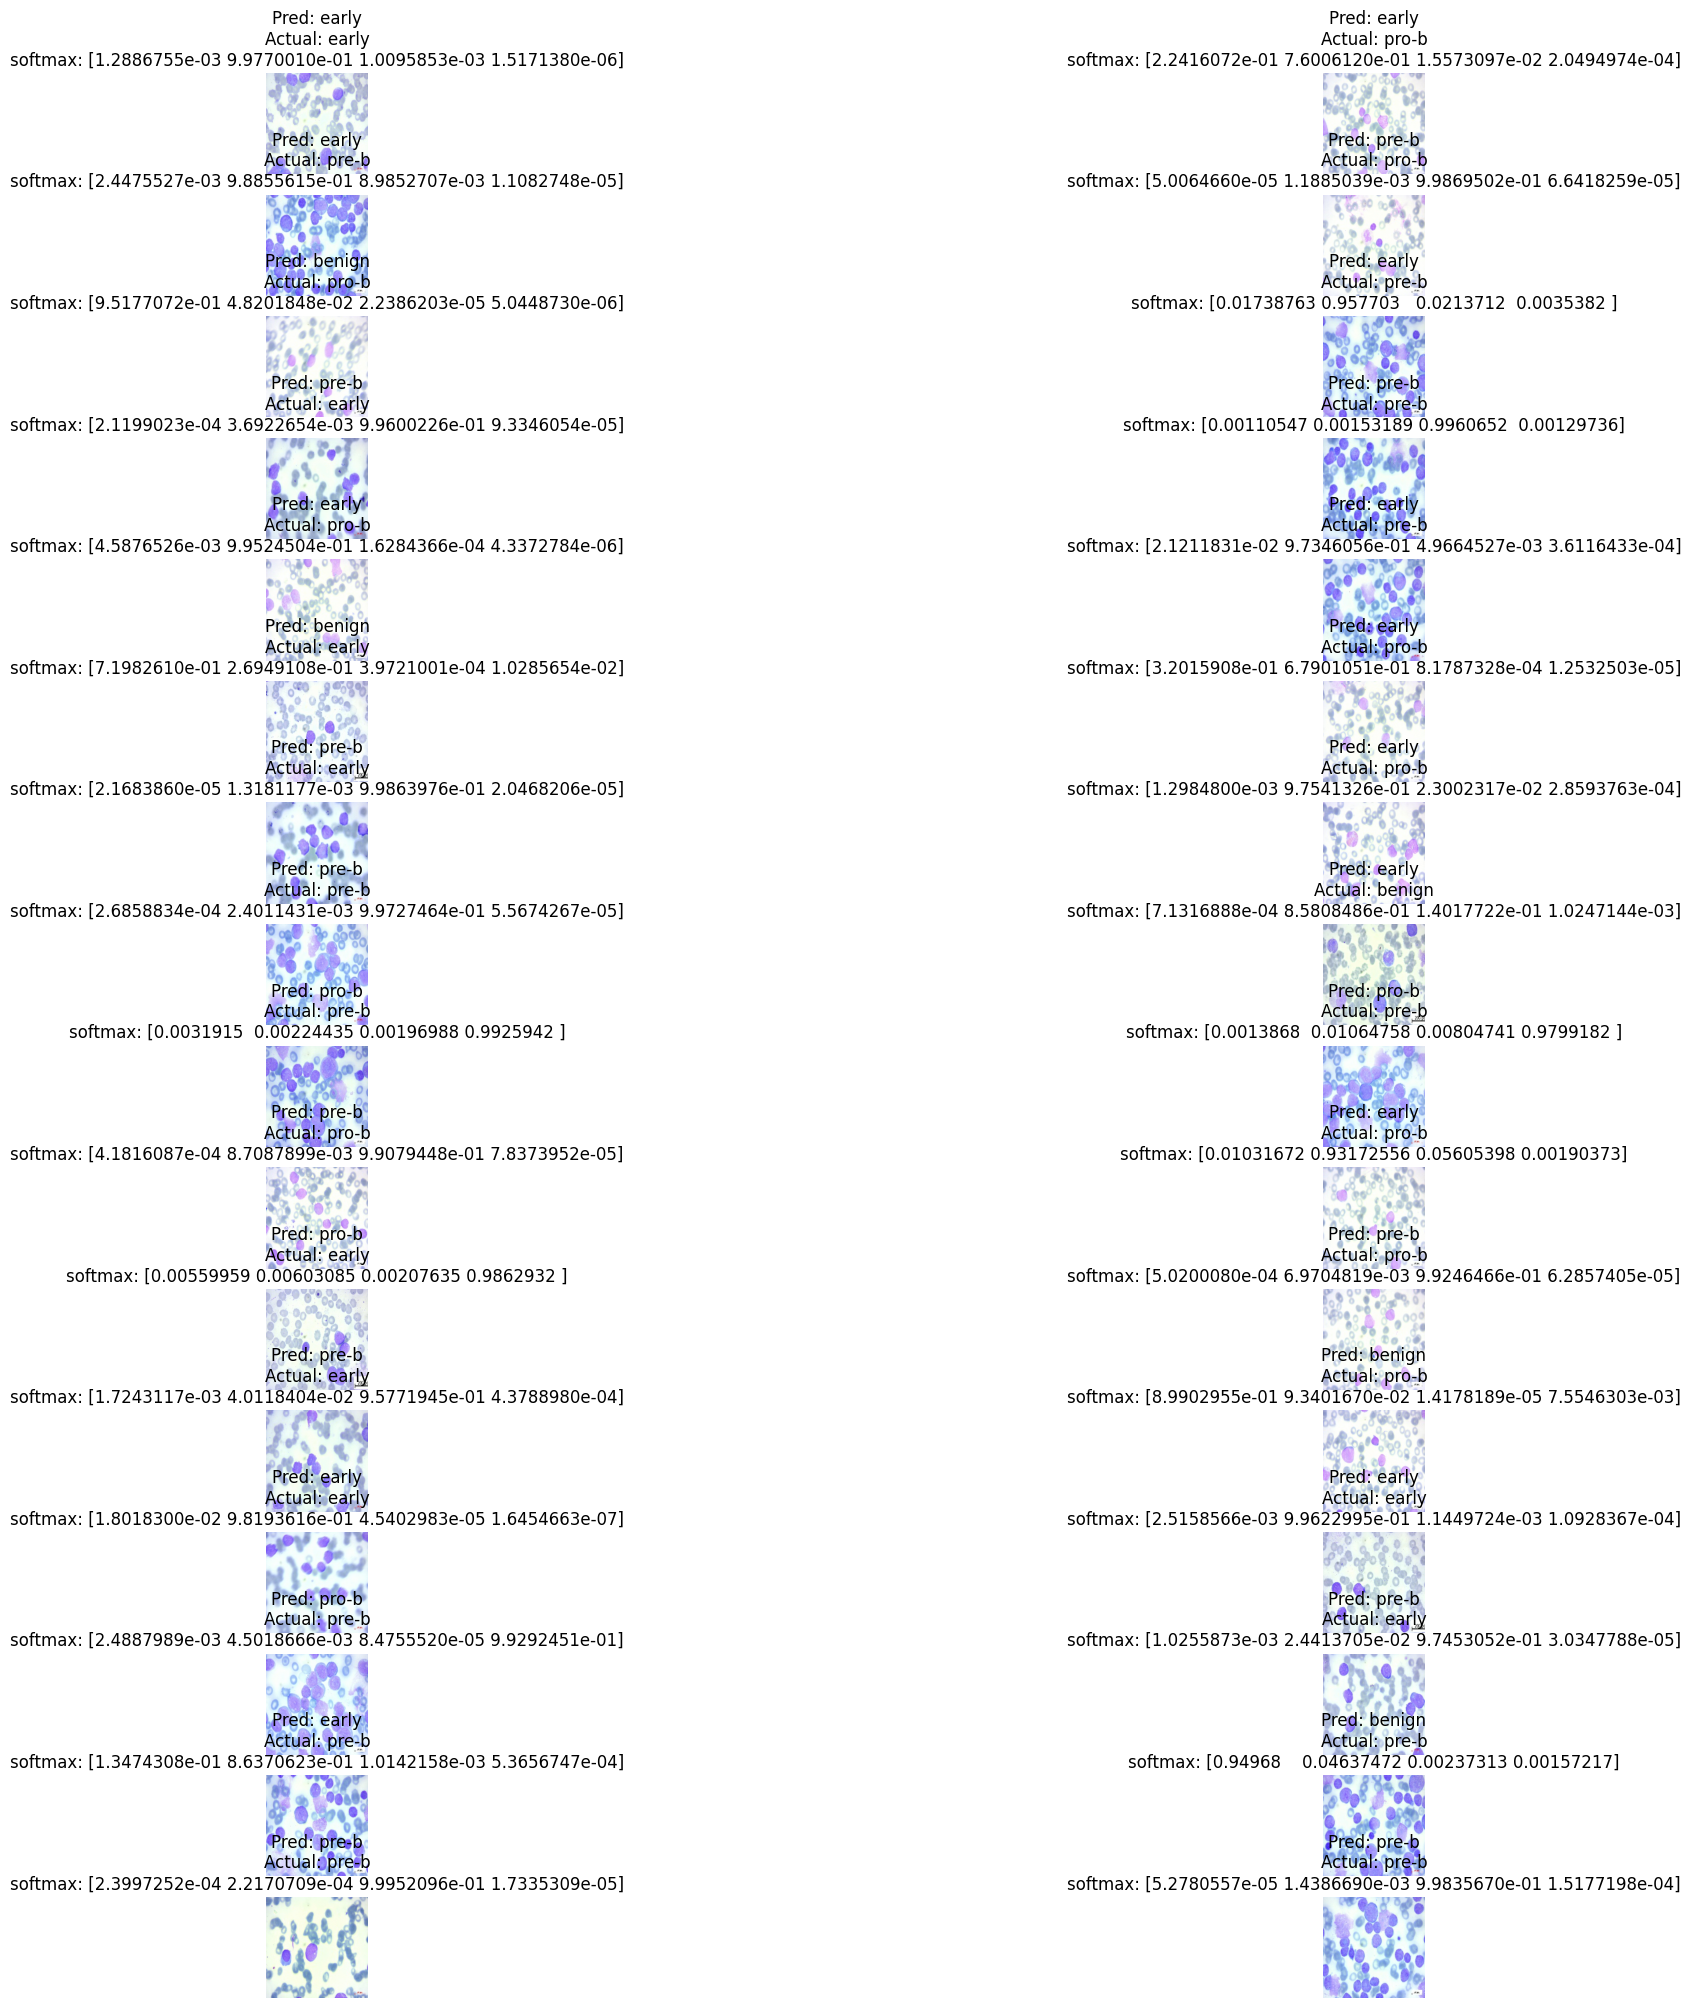

In [ ]:
# Make predictions on the test subset
predictions = model.predict(test)

# Display predictions vs actual results
plt.figure(figsize=(25, 25))
for i, (images, labels) in enumerate(test.take(1)):
    for j in range(len(images)):
        ax = plt.subplot(16, 2, j + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        predicted_label = class_names[np.argmax(predictions[i * len(images) + j])]
        actual_label = class_names[labels[j].numpy()]
        plt.title(f'Pred: {predicted_label}\nActual: {actual_label}\nsoftmax: {predictions[i * len(images) + j]}')
        
        plt.axis("off")

FileUpload(value=(), accept='image/*', description='Upload')

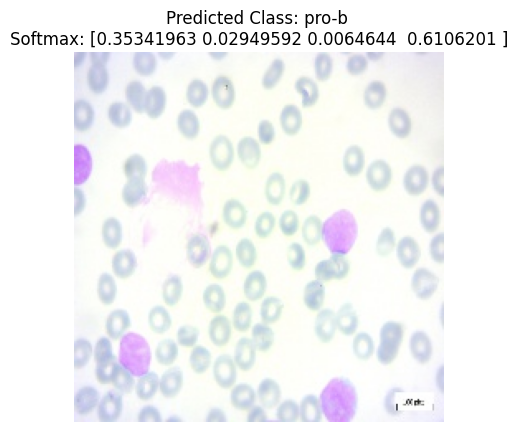

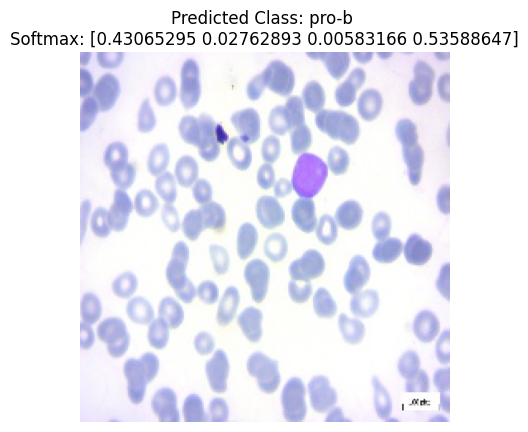

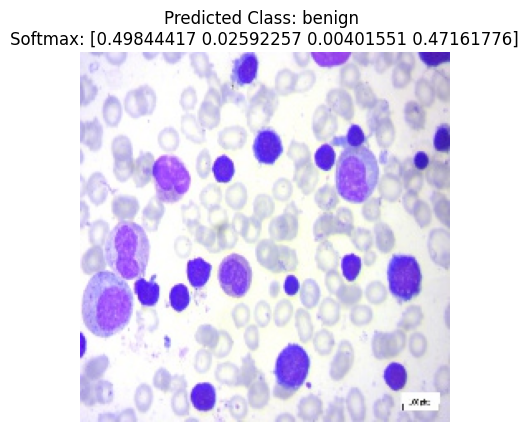

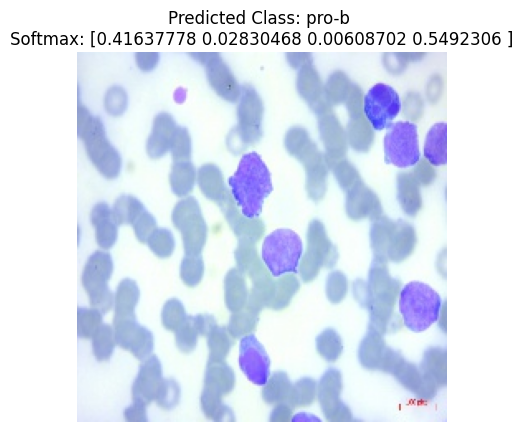

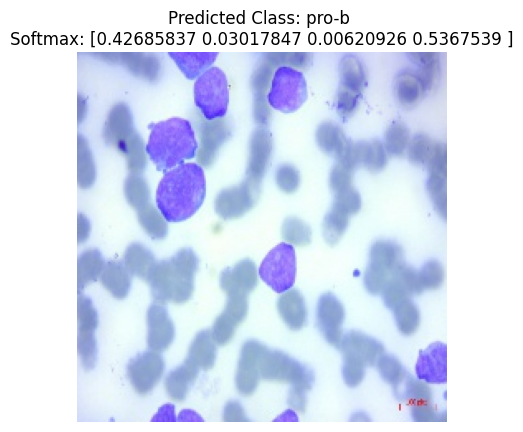

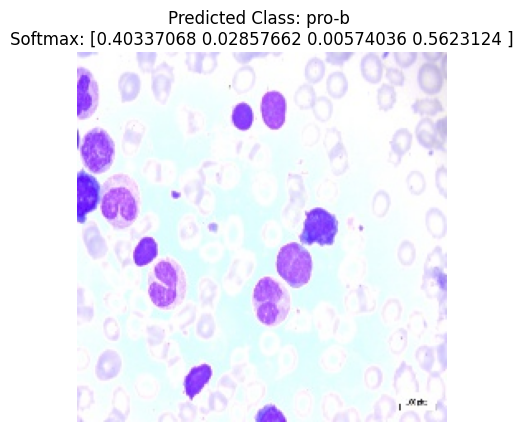

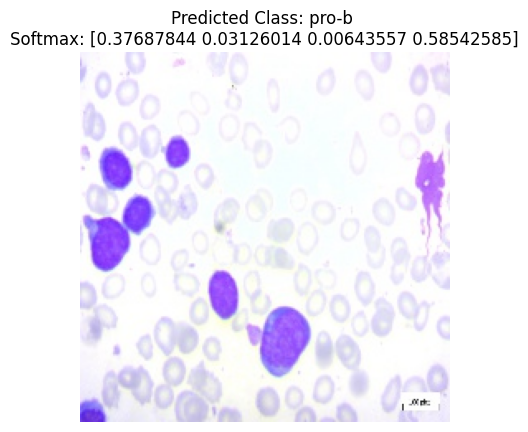

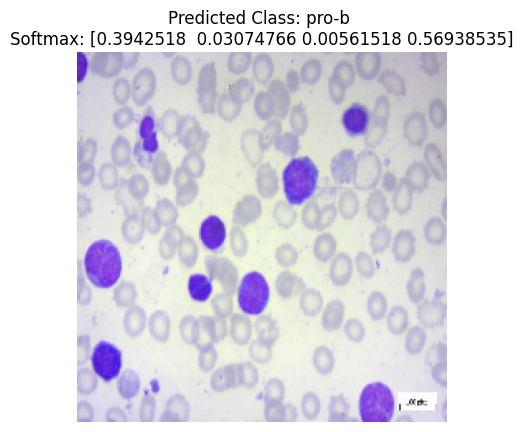

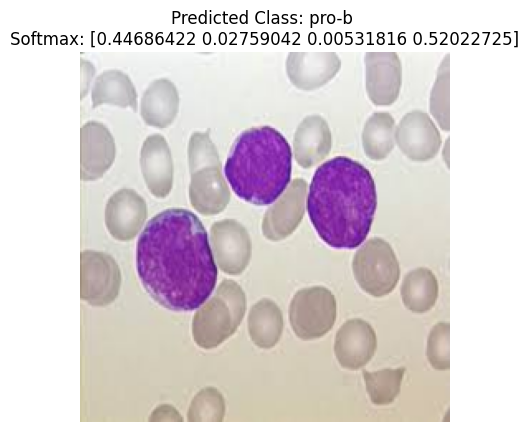

In [ ]:
import io
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


model = load_model('restnet_model.keras')
class_names = ['benign', 'early', 'pre-b', 'pro-b']

# Create file upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

# Prediction function
def predict_image(change):
    if upload_widget.value:
        # Get the first file (since multiple=False)
        uploaded_file = upload_widget.value[0]
        content = uploaded_file['content']

        # Open and preprocess image
        img = Image.open(io.BytesIO(content)).convert('RGB').resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        prediction = model.predict(img_array)
        predicted_class = class_names[np.argmax(prediction)]

        # Display results
        plt.imshow(img)
        plt.title(f'Predicted Class: {predicted_class} \nSoftmax: {prediction[0]}')
        
        plt.axis('off')
        plt.show()

# Attach the function to the upload widget
upload_widget.observe(predict_image, names='value')

# Display the widget
display(upload_widget)


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_single_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 3)
    img_array /= 255.0  # Rescale just like training!
    return img_array

img = preprocess_single_image('/Users/gamalielmarines/Downloads/CNN-Reto-Benji/ALL Image Dataset/Original/Pro/WBC-Malignant-Pro-006.jpg')
prediction = model.predict(img)
predicted_class = np.argmax(prediction)
print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted class: 0


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_single_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img).astype('float32')
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # This does the -1 to 1 normalization
    return img_array


In [ ]:
img = preprocess_single_image('/Users/gamalielmarines/Downloads/CNN-Reto-Benji/ALL Image Dataset/Original/Pro/WBC-Malignant-Pro-006.jpg')
pred = model.predict(img)
print("Raw prediction:", pred)
print("Predicted class index:", np.argmax(pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Raw prediction: [[0.71091765 0.05623617 0.01693396 0.21591225]]
Predicted class index: 0


In [ ]:
print(pred)


[[0.71091765 0.05623617 0.01693396 0.21591225]]


In [ ]:
paths = [
    '/Users/gamalielmarines/Downloads/CNN-Reto-Benji/ALL Image Dataset/Original/Pro/WBC-Malignant-Pro-001.jpg',
    '/Users/gamalielmarines/Downloads/CNN-Reto-Benji/ALL Image Dataset/Original/Pre/WBC-Malignant-Pre-001.jpg',
    '/Users/gamalielmarines/Downloads/CNN-Reto-Benji/ALL Image Dataset/Original/Early/WBC-Malignant-Early-001.jpg',
    '/Users/gamalielmarines/Downloads/CNN-Reto-Benji/ALL Image Dataset/Original/Benign/WBC-Benign-001.jpg'
]

for path in paths:
    img = preprocess_single_image(path)
    pred = model.predict(img)
    print(f"Image: {path}")
    print("Softmax:", pred)
    print("Predicted:", np.argmax(pred))
    print("-" * 30)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Image: /Users/gamalielmarines/Downloads/CNN-Reto-Benji/ALL Image Dataset/Original/Pro/WBC-Malignant-Pro-001.jpg
Softmax: [[0.708694   0.05753899 0.01711707 0.2166499 ]]
Predicted: 0
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Image: /Users/gamalielmarines/Downloads/CNN-Reto-Benji/ALL Image Dataset/Original/Pre/WBC-Malignant-Pre-001.jpg
Softmax: [[0.77125704 0.04767149 0.01336706 0.16770439]]
Predicted: 0
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Image: /Users/gamalielmarines/Downloads/CNN-Reto-Benji/ALL Image Dataset/Original/Early/WBC-Malignant-Early-001.jpg
Softmax: [[0.7440543  0.05224895 0.01519665 0.18850017]]
Predicted: 0
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Image: /Users/gamalielmarines/Downloads/CNN-Reto-Benji/ALL Image Dataset/Original/Benign/WBC-Benign-001.jpg
Softmax: [[0.711891   0.06171793 0.01629359 0.21009754]]
Predicted: 0
-------------------------